In [0]:
import os
os.chdir("drive/My Drive/reddit")


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('rindia_ver2.csv')
df.head()

,ID,Title,Author,Date,Post,Flair
0,5lcsj7,Still 97 per cent support Modi over demonetisa...,72VirginPimp,01-01-2017 06:44,NaN,Demonetization
1,5lct38,Amazon starts p2p selling in Bangalore competi...,jkicha,01-01-2017 06:47,NaN,Self-promotion.
2,5lcwlv,Indian Idol 31 December 2016 Full Episode,[deleted],01-01-2017 07:11,[deleted],Entertainment
3,5lcxpz,Preacher for pm?,[deleted],01-01-2017 07:18,[removed],NaN
4,5lcxxt,♡ Happy New Year 2017 ♡,[deleted],01-01-2017 07:20,[deleted],Not in English.


In [4]:
df.dropna(subset = ['Flair'], inplace = True)
df.isnull().sum()

ID             0
Title          1
Author         0
Date           0
Post      265639
Flair          0
dtype: int64

In [5]:
len(df)

369738

In [6]:
count = 0
for i in df["Flair"].value_counts():
  if i > 10000:
    count += 1
  else : 
    break
labels = df["Flair"].value_counts()[:count]
def dummy(i):
  if i in labels:
    return True
  else:
    return False
df['Filter'] = df["Flair"].map(dummy)
df.head()




,ID,Title,Author,Date,Post,Flair,Filter
0,5lcsj7,Still 97 per cent support Modi over demonetisa...,72VirginPimp,01-01-2017 06:44,NaN,Demonetization,False
1,5lct38,Amazon starts p2p selling in Bangalore competi...,jkicha,01-01-2017 06:47,NaN,Self-promotion.,False
2,5lcwlv,Indian Idol 31 December 2016 Full Episode,[deleted],01-01-2017 07:11,[deleted],Entertainment,False
4,5lcxxt,♡ Happy New Year 2017 ♡,[deleted],01-01-2017 07:20,[deleted],Not in English.,False
5,5lcz4n,[P] Preacher for a PM ?,Preacherm,01-01-2017 07:28,[removed],Unsourced Assertion.,False


In [7]:
labels

Non-Political         98703
Politics              97497
AskIndia              47464
Policy/Economy        20935
Business/Finance      19654
Science/Technology    16187
Name: Flair, dtype: int64

In [8]:
reduced_df = df[df["Filter"]]
reduced_df.head()

,ID,Title,Author,Date,Post,Flair,Filter
8,5ld227,People who went partying out tonight:,ooops_i_did_it_again,01-01-2017 07:48,"Dear randians, since everyone is asking loners...",AskIndia,True
11,5ld4tn,Record 25 Per Cent Rise In Number Of Indian St...,curiousgeek123,01-01-2017 08:08,NaN,Non-Political,True
12,5ld9hf,A year of outrageous lies: From economic growt...,udi_baaba,01-01-2017 08:42,NaN,Politics,True
13,5ldbjh,Bhopal Gas Tragedy | World's Worst Industrial ...,[deleted],01-01-2017 08:58,NaN,Non-Political,True
15,5ldcop,Indian in Saudi Arabia arrested on charges of ...,TemptNotTheBlade,01-01-2017 09:07,NaN,Non-Political,True


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


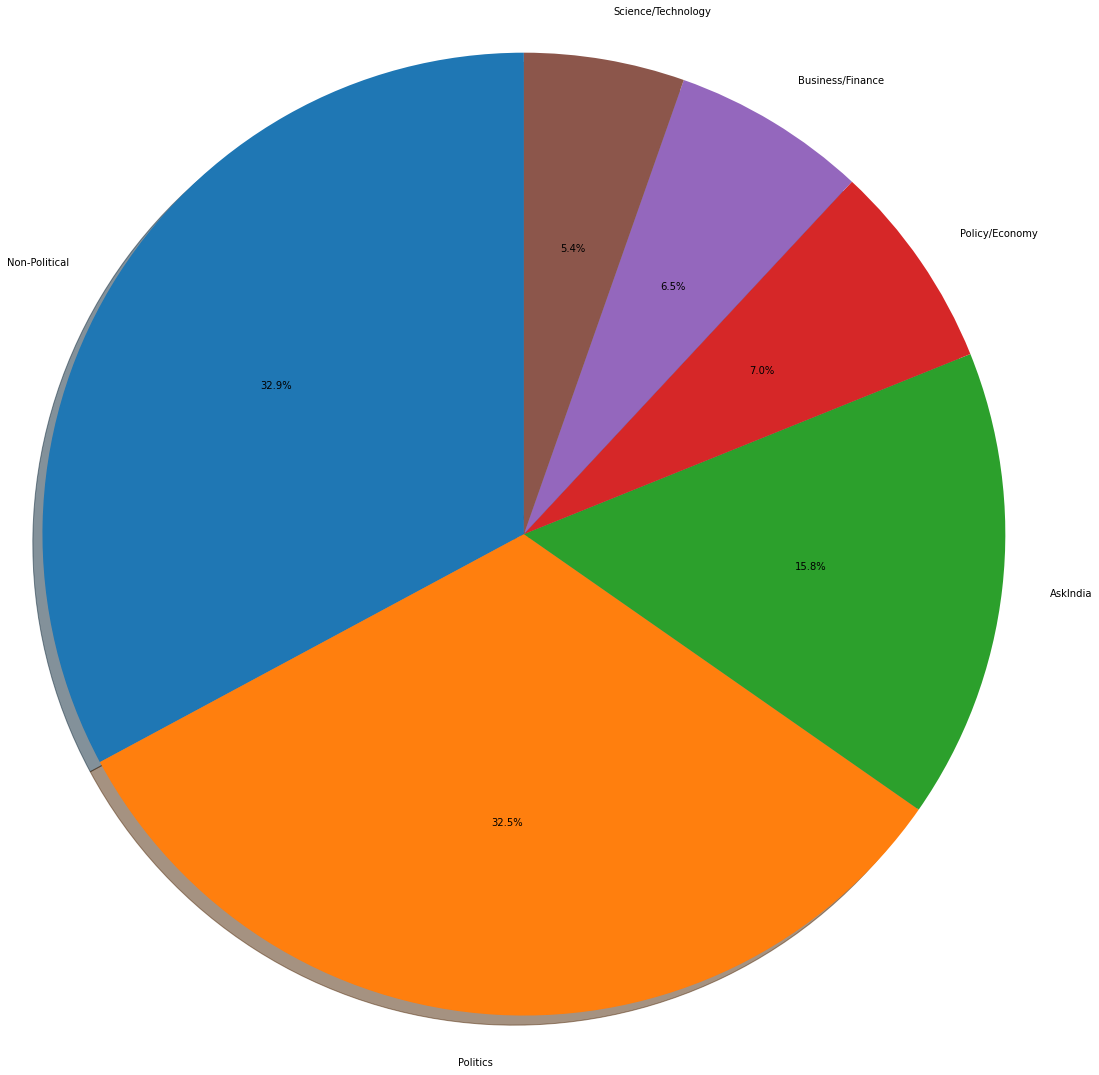

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
lab = labels.index
sizes = labels.values
 
fig1, ax1 = plt.subplots(figsize = (15,15))
ax1.pie(sizes, explode=None, labels=lab, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [0]:
import nltk
#nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 


stop_words =set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer() 
tokenizer = RegexpTokenizer(r'\w+')
def preprocess(text):
  word_list = []
  tok = tokenizer.tokenize(text)
  for word in tok:
    if word not in stop_words:
      word_list.append(lemmatizer.lemmatize(word))
  return " ".join(word_list)

In [11]:
reduced_df['Title'] = reduced_df['Title'].apply(preprocess)
reduced_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,Title,Author,Date,Post,Flair,Filter
8,5ld227,People went partying tonight,ooops_i_did_it_again,01-01-2017 07:48,"Dear randians, since everyone is asking loners...",AskIndia,True
11,5ld4tn,Record 25 Per Cent Rise In Number Of Indian St...,curiousgeek123,01-01-2017 08:08,NaN,Non-Political,True
12,5ld9hf,A year outrageous lie From economic growth job...,udi_baaba,01-01-2017 08:42,NaN,Politics,True
13,5ldbjh,Bhopal Gas Tragedy World Worst Industrial Disa...,[deleted],01-01-2017 08:58,NaN,Non-Political,True
15,5ldcop,Indian Saudi Arabia arrested charge blasphemy,TemptNotTheBlade,01-01-2017 09:07,NaN,Non-Political,True


In [12]:
from keras.utils import to_categorical
reduced_df["Flair"] = reduced_df["Flair"].astype("category")
cat_dict = dict(enumerate(reduced_df['Flair'].cat.categories))
encoded = reduced_df["Flair"].cat.codes



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state= 42 )
for train_index, test_index in skf.split(reduced_df["Flair"].values, encoded):
  Xtrain = reduced_df["Title"].values[train_index]
  ytrain = encoded.values[train_index]
  Xtest = reduced_df["Title"].values[test_index]
  ytest = encoded.values[test_index]
  break


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5,norm='l2',encoding='latin-1', stop_words="english")
x_train_tfidf = vectorizer.fit_transform(Xtrain)
x_test_tfidf = vectorizer.transform(Xtest)

In [55]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).tail()

,idf_weights
new trick,11.598104
new train,11.598104
new trade,11.598104
new worry,11.598104
ரம,11.598104


In [0]:
# from sklearn.feature_selection import SelectPercentile, f_classif
# selector = SelectPercentile(f_classif, percentile=10)
# selected_train = selector.fit_transform(x_train_tfidf, ytrain).toarray()
# selected_test = selector.transform(x_test_tfidf).toarray()

In [56]:
x_train_tfidf.shape

(240352, 58099)

In [57]:
from sklearn.feature_selection import chi2
N = 2
for category_id, Value in sorted(cat_dict.items()):
  features_chi2 = chi2(x_train_tfidf, ytrain == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Value))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AskIndia':
  . Most correlated unigrams:
. help
. askindia
  . Most correlated bigrams:
. need advice
. need help
# 'Business/Finance':
  . Most correlated unigrams:
. manufacturers
. grotal
  . Most correlated bigrams:
. exporters india
. manufacturers india
# 'Non-Political':
  . Most correlated unigrams:
. modi
. np
  . Most correlated bigrams:
. rahul gandhi
. year old
# 'Policy/Economy':
  . Most correlated unigrams:
. gst
. economy
  . Most correlated bigrams:
. india economy
. indian economy
# 'Politics':
  . Most correlated unigrams:
. modi
. bjp
  . Most correlated bigrams:
. rahul gandhi
. pm modi
# 'Science/Technology':
  . Most correlated unigrams:
. galaxy
. isro
  . Most correlated bigrams:
. launched india
. samsung galaxy


In [0]:
# ytrain = to_categorical(ytrain)
# ytest = to_categorical(ytest)  

In [59]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
MultiNB = MultinomialNB()
MultiNB.fit(x_train_tfidf, ytrain)
print(f"Training Score : {MultiNB.score(x_train_tfidf, ytrain)}")
print(f"Test Score : {MultiNB.score(x_test_tfidf, ytest)}")

Training Score : 0.6791622287311943
Test Score : 0.6300758886965784


In [69]:
print(f"predicted class for {Xtest[0]} : {cat_dict[MultiNB.predict(x_test_tfidf[0])[0]]}\nActual class : {cat_dict[ytest[0]]}")

predicted class for People went partying tonight : AskIndia
Actual class : AskIndia


In [71]:
svc = LinearSVC()
svc.fit(x_train_tfidf, ytrain)
print(f"Training Score : {svc.score(x_train_tfidf, ytrain)}")
print(f"Test Score : {svc.score(x_test_tfidf, ytest)}")
print(f"predicted class for {Xtest[0]} : {cat_dict[svc.predict(x_test_tfidf[0])[0]]}\nActual class : {cat_dict[ytest[0]]}")

Training Score : 0.7936276794035415
Test Score : 0.6455698309146585
predicted class for People went partying tonight : AskIndia
Actual class : AskIndia


In [72]:
lr = LogisticRegression()
lr.fit(x_train_tfidf, ytrain)
print(f"Training Score : {lr.score(x_train_tfidf, ytrain)}")
print(f"Test Score : {lr.score(x_test_tfidf, ytest)}")
print(f"predicted class for {Xtest[0]} : {cat_dict[lr.predict(x_test_tfidf[0])[0]]}\nActual class : {cat_dict[ytest[0]]}")

Training Score : 0.7005059246438556
Test Score : 0.6514944747703368
predicted class for People went partying tonight : Non-Political
Actual class : AskIndia


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [75]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier([('lr',lr), ('svc',svc),("nb",MultiNB)])
voting.fit(x_train_tfidf,ytrain)
print(f"Training Score : {voting.score(x_train_tfidf, ytrain)}")
print(f"Test Score : {voting.score(x_test_tfidf, ytest)}")
print(f"predicted class for {Xtest[0]} : {cat_dict[voting.predict(x_test_tfidf[0])[0]]}\nActual class : {cat_dict[ytest[0]]}")


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Score : 0.7293344761017175
Test Score : 0.6547397150845427
predicted class for People went partying tonight : AskIndia
Actual class : AskIndia


In [0]:
import pickle
models = [voting, lr, svc, MultiNB, vectorizer]
names = ["voting", "lr", "svc", "vectorizer"]
for model , name in zip(models, names):
  save_classifier = open(f"{name}.pickle","wb")
  pickle.dump(model, save_classifier)
  save_classifier.close()

Text(0.5, 1.0, 'Confusion Matrix for Voting Classifier')

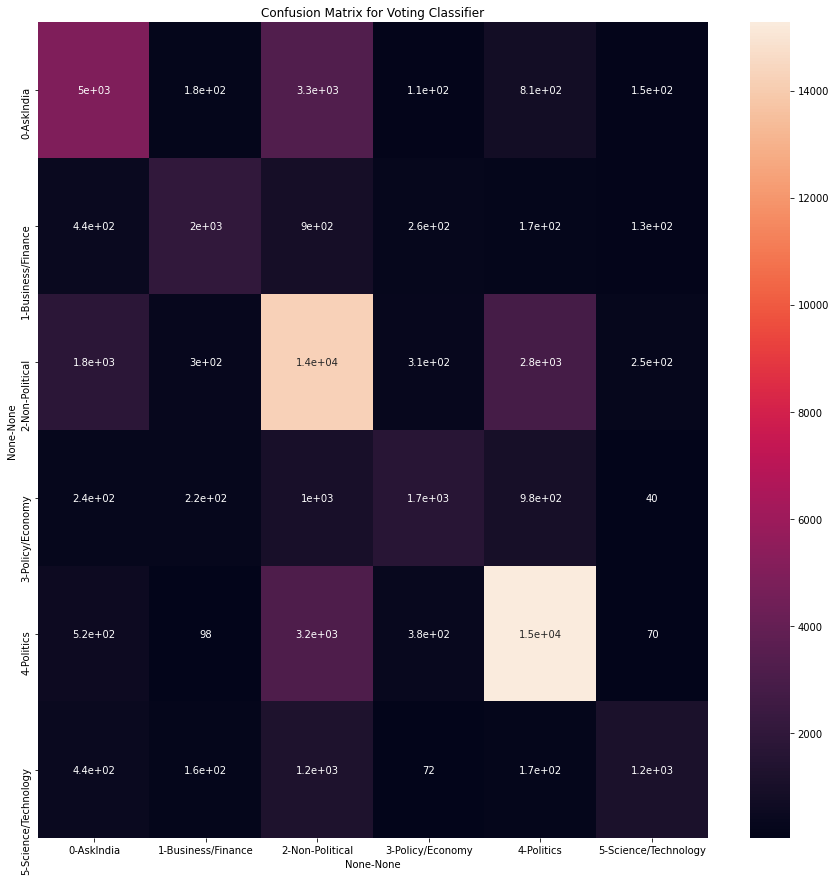

In [82]:
from sklearn import metrics
pred = voting.predict(x_test_tfidf)
cm=metrics.confusion_matrix(ytest,pred)
cm = pd.DataFrame(cm, index = cat_dict.items(), columns=cat_dict.items())
plt.figure(figsize = (15,15))
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for Voting Classifier")

All the correct predictions are in order of 10^3 and all the false predictions are in order of 10^2, so the performance of the model is decent.(except for the categories that are dominant)

The model is biased but in this case we want it to represent and predict on real time distribution of data.